<a href="https://colab.research.google.com/github/KamiraPagulayan/CCRNFLRL_COM221_PROJECT/blob/main/1K_Episode/%5BRL%5D2048_Actor_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [ ]:
!pip install --upgrade pip
!pip install gymnasium==0.29.1 gymnasium-2048 torch numpy matplotlib imageio --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


# Imports

In [ ]:
import os
import time
import heapq
import base64
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import gymnasium_2048
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# Device Setup

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


# Environment Setup

In [ ]:
ENV_ID = "gymnasium_2048:gymnasium_2048/TwentyFortyEight-v0"
print("Using ENV_ID:", ENV_ID)

Using ENV_ID: gymnasium_2048:gymnasium_2048/TwentyFortyEight-v0


# Actor-Critic Model

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, obs_shape, n_actions):
        super().__init__()
        if len(obs_shape) == 3:
            h, w, c = obs_shape
            if c >= max(h, w):
                self.channels_last = True
                C, H, W = c, h, w
            else:
                self.channels_last = False
                C, H, W = obs_shape
        else:
            self.channels_last = False
            C, H, W = obs_shape[0], obs_shape[1], obs_shape[2]

        self.C, self.H, self.W = int(C), int(H), int(W)
        self.conv = nn.Conv2d(self.C, 128, kernel_size=2, stride=1)
        conv_out_h = max(1, self.H - 1)
        conv_out_w = max(1, self.W - 1)
        flattened = 128 * conv_out_h * conv_out_w

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened, 256),
            nn.ReLU(),
        )
        self.actor = nn.Linear(256, n_actions)
        self.critic = nn.Linear(256, 1)

    def _prepare(self, x):
        if isinstance(x, np.ndarray):
            t = torch.from_numpy(x).to(torch.float32)
        elif torch.is_tensor(x):
            t = x.to(torch.float32)
        else:
            t = torch.tensor(x, dtype=torch.float32)
        t = t.to(device)
        if t.dim() == 3:
            if self.channels_last and t.shape[2] == self.C:
                t = t.permute(2, 0, 1)
            t = t.unsqueeze(0)
        elif t.dim() == 4:
            if self.channels_last and t.shape[3] == self.C:
                t = t.permute(0, 3, 1, 2)
        else:
            t = t.view(1, self.C, self.H, self.W)
        return t

    def forward(self, x):
        x = self._prepare(x)
        feat = F.relu(self.conv(x))
        feat = self.mlp(feat)
        logits = self.actor(feat)
        value = self.critic(feat).squeeze(-1)
        return logits, value

    def act(self, obs, deterministic=False):
        logits, _ = self.forward(obs)
        probs = F.softmax(logits, dim=-1)
        if deterministic:
            action = torch.argmax(probs, dim=-1)
            return int(action.item()), float(probs[0, action.item()].item())
        else:
            dist = torch.distributions.Categorical(probs)
            a = dist.sample()
            return int(a.item()), float(probs[0, a.item()].item())

# Helper: pad frame to multiple of 16

In [ ]:
def pad_to_macroblock(frame, block_size=16):
    h, w = frame.shape[:2]
    new_h = ((h + block_size - 1) // block_size) * block_size
    new_w = ((w + block_size - 1) // block_size) * block_size
    padded = np.zeros((new_h, new_w, 3), dtype=frame.dtype)
    padded[:h, :w, :] = frame
    return padded

# Training with Top-K Episode Tracking

In [ ]:
def train_and_track_topk(
    env_id=ENV_ID,
    episodes=1000,
    gamma=0.99,
    lr=1e-4,
    eval_interval=100,
    max_steps_per_episode=500,
    top_k=10,
    fps=5,
    downsample=True,
    downsample_factor=2,
    tmp_dir="episode_tmp",
    save_path="ac_2048.pth",
):
    os.makedirs(tmp_dir, exist_ok=True)
    env = gym.make(env_id, size=4, max_pow=16, render_mode="rgb_array")
    obs_shape = env.observation_space.shape
    n_actions = env.action_space.n

    model = ActorCritic(obs_shape=obs_shape, n_actions=n_actions).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    reward_history = []
    avg_rewards = []
    kept_heap = []  # min-heap for top-k episodes
    start_time = time.time()

    for ep in range(1, episodes + 1):
        obs, info = env.reset()
        done = False
        steps = 0
        ep_tmpfile = os.path.join(tmp_dir, f"ep_{ep:05d}.mp4")
        writer = imageio.get_writer(ep_tmpfile, fps=fps, codec="libx264", quality=8)

        log_probs = []
        values = []
        rewards = []

        while not done and steps < max_steps_per_episode:
            steps += 1
            frame = env.render()
            if frame is None:
                break

            # downsample toggle
            frame_to_write = frame if not downsample else frame[::downsample_factor, ::downsample_factor]
            # pad to 16×16 multiple
            frame_to_write = pad_to_macroblock(frame_to_write)
            writer.append_data(frame_to_write)

            logits, value = model.forward(obs)
            probs = F.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)
            next_obs, reward, terminated, truncated, info = env.step(int(action.item()))
            done = terminated or truncated

            log_probs.append(log_prob.squeeze(0))
            values.append(value.squeeze(0))
            rewards.append(float(reward))
            obs = next_obs

        writer.close()

        total_reward = float(sum(rewards)) if rewards else 0.0
        reward_history.append(total_reward)

        # maintain top-k heap
        if len(kept_heap) < top_k:
            heapq.heappush(kept_heap, (total_reward, ep_tmpfile, ep))
        else:
            if total_reward > kept_heap[0][0]:
                to_remove = heapq.heappushpop(kept_heap, (total_reward, ep_tmpfile, ep))
                try:
                    os.remove(to_remove[1])
                except Exception:
                    pass
            else:
                try:
                    os.remove(ep_tmpfile)
                except Exception:
                    pass

        # policy & value update
        if rewards:
            returns = []
            R = 0.0
            for r in reversed(rewards):
                R = r + gamma * R
                returns.insert(0, R)
            returns = torch.tensor(returns, dtype=torch.float32, device=device)
            vals = torch.stack(values)
            logp = torch.stack(log_probs)
            advantages = returns - vals.detach()
            policy_loss = -(logp * advantages).mean()
            value_loss = F.mse_loss(vals, returns)
            loss = policy_loss + 0.5 * value_loss
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

        # logging
        if ep % eval_interval == 0:
            avg = np.mean(reward_history[-eval_interval:])
            avg_rewards.append(avg)
            elapsed = time.time() - start_time
            print(f"Episode {ep}/{episodes} | Avg reward (last {eval_interval}): {avg:.2f} | Elapsed {elapsed:.1f}s")
            torch.save(model.state_dict(), save_path)

    env.close()
    torch.save(model.state_dict(), save_path)
    print("Training finished, model saved to", save_path)
    top_list = sorted(kept_heap, key=lambda x: x[0], reverse=True)
    return model, reward_history, avg_rewards, top_list, tmp_dir

# Combine and Display Top Episodes

In [ ]:
def stitch_and_display(top_list, out_video="top10_overall.mp4", fps=5, separator_frames=8, remove_sources=True):
    if len(top_list) == 0:
        raise RuntimeError("No top episodes to stitch.")
    print(f"Stitching {len(top_list)} episodes into {out_video} ...")
    with imageio.get_writer(out_video, fps=fps, codec="libx264", quality=8) as final_writer:
        for rank, (reward, filepath, ep_idx) in enumerate(top_list, start=1):
            print(f"Appending Rank {rank}: Ep {ep_idx} | Reward {reward:.2f}")
            try:
                reader = imageio.get_reader(filepath, 'ffmpeg')
                last_frame = None
                for frame in reader:
                    final_writer.append_data(frame)
                    last_frame = frame
                reader.close()
            except Exception as e:
                print("Warning: failed to read", filepath, " — skipping. Error:", e)
                continue
            if last_frame is not None:
                for _ in range(separator_frames):
                    final_writer.append_data(last_frame)

    if remove_sources:
        for _, fp, _ in top_list:
            try:
                os.remove(fp)
            except Exception:
                pass

    filesize_mb = os.path.getsize(out_video) / (1024*1024)
    if filesize_mb > 200:
        print(f"Warning: final video is large ({filesize_mb:.1f} MB). Displaying inline will temporarily use memory.")
    mp4 = open(out_video, "rb").read()
    data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
    return HTML(f'<video width="720" controls><source src="{data_url}" type="video/mp4"></video>')

# Run Training

In [ ]:
TOTAL_EPISODES = 1000
TOP_K = 10
FPS = 5
DOWNSAMPLE = False          # Safe mode (low-res)
DOWNSAMPLE_FACTOR = 1      # 1 = full resolution
TMP_DIR = "topk_episode_tmp"
OUT_VIDEO = "top10_overall.mp4"
SEPARATOR_FRAMES = 8

model, reward_history, avg_rewards, top_list, tmp_dir_used = train_and_track_topk(
    env_id=ENV_ID,
    episodes=TOTAL_EPISODES,
    gamma=0.99,
    lr=1e-4,
    eval_interval=50,
    max_steps_per_episode=500,
    top_k=TOP_K,
    fps=FPS,
    downsample=DOWNSAMPLE,
    downsample_factor=DOWNSAMPLE_FACTOR,
    tmp_dir=TMP_DIR,
    save_path="ac_2048.pth"
)

Episode 50/1000 | Avg reward (last 50): 1143.52 | Elapsed 78.8s
Episode 100/1000 | Avg reward (last 50): 1081.44 | Elapsed 155.9s
Episode 150/1000 | Avg reward (last 50): 1004.64 | Elapsed 229.2s
Episode 200/1000 | Avg reward (last 50): 961.84 | Elapsed 304.8s
Episode 250/1000 | Avg reward (last 50): 845.36 | Elapsed 382.8s
Episode 300/1000 | Avg reward (last 50): 908.72 | Elapsed 480.9s
Episode 350/1000 | Avg reward (last 50): 952.16 | Elapsed 571.4s
Episode 400/1000 | Avg reward (last 50): 1021.52 | Elapsed 651.9s
Episode 450/1000 | Avg reward (last 50): 1109.12 | Elapsed 742.4s
Episode 500/1000 | Avg reward (last 50): 1352.88 | Elapsed 842.7s
Episode 550/1000 | Avg reward (last 50): 1441.28 | Elapsed 948.7s
Episode 600/1000 | Avg reward (last 50): 1752.56 | Elapsed 1088.9s
Episode 650/1000 | Avg reward (last 50): 1712.72 | Elapsed 1240.3s
Episode 700/1000 | Avg reward (last 50): 2050.40 | Elapsed 1404.0s
Episode 750/1000 | Avg reward (last 50): 1385.76 | Elapsed 1544.0s
Episode 800/

# Training Progress

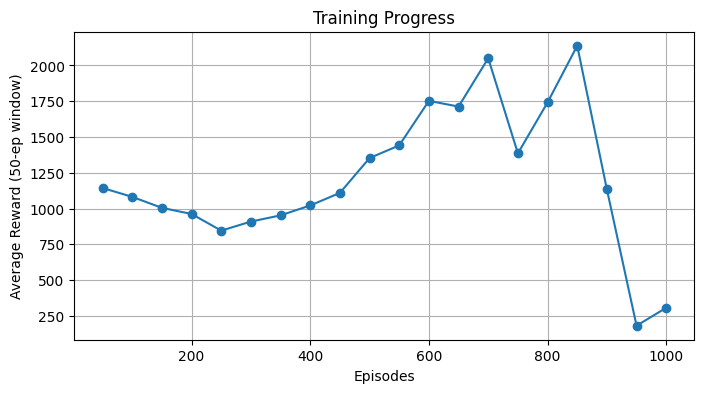

In [ ]:
if len(avg_rewards) > 0:
    plt.figure(figsize=(8,4))
    plt.plot(np.arange(1, len(avg_rewards)+1)*50, avg_rewards, marker='o')
    plt.xlabel("Episodes")
    plt.ylabel("Average Reward (50-ep window)")
    plt.title("Training Progress")
    plt.grid(True)
    plt.show()

# Combine and Display Final Top-10 Video

In [ ]:
html = stitch_and_display(top_list, out_video=OUT_VIDEO, fps=FPS, separator_frames=SEPARATOR_FRAMES)
display(html)

Stitching 10 episodes into top10_overall.mp4 ...
Appending Rank 1: Ep 814 | Reward 4444.00
Appending Rank 2: Ep 816 | Reward 4232.00
Appending Rank 3: Ep 676 | Reward 3960.00
Appending Rank 4: Ep 812 | Reward 3816.00
Appending Rank 5: Ep 869 | Reward 3756.00
Appending Rank 6: Ep 616 | Reward 3644.00
Appending Rank 7: Ep 607 | Reward 3640.00
Appending Rank 8: Ep 779 | Reward 3636.00
Appending Rank 9: Ep 561 | Reward 3624.00
Appending Rank 10: Ep 780 | Reward 3624.00
